In [29]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import Config
import datetime
import time
import copy
import BS

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score

from pymongo import MongoClient
client=MongoClient(Config.DB_Hostname,Config.DB_Port)

def _calc_spread_return(spot, long_start, long_end, short_start, short_end, strike_spread):
    
    spread_benefit = short_start - long_start
    margin = spot*0.02 - spread_benefit
    brokerage = (long_start + long_end + short_start + short_end) * 0.001
    
    if spread_benefit > 0:
        margin += strike_spread
        
    if margin <0:
        print(f"Error_{margin}")
    
    return (long_end - long_start + short_start - short_end - brokerage)/margin


class Gap_Move_Classifier:
    
    def __init__(self, start_date, end_date, prediction_date, underlying, start_holding_period, end_holding_period):
        
        self.start_date = start_date #2017-01-01
        self.end_date = end_date #2017-01-01
        self.prediction_date = prediction_date #2017-01-01
        self.underlying = underlying #NIFTY, BANKNIFTY
        self.underlying_dynamics = None
        self.vol_surface = None
        self.days_to_expiry = None
        self.data_matrix = None
        self.return_matrix = None
        self.price_matrix = None
        self.performance_stats = None
        self.start_holding_period = start_holding_period #in minutes
        self.end_holding_period = end_holding_period #in minutes
        self.strike_range = [-1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5]
        
        #start = time.time()
        self.underlying_dynamics = pd.DataFrame(client[f'{Config.Data_DB}'][f'{self.underlying}OHLC'].find())
        self.underlying_dynamics.drop(columns=['_id'],inplace=True)
        self.underlying_dynamics.sort_values(['date','batch_id'],inplace=True)
        self.underlying_dynamics=self.underlying_dynamics[(self.underlying_dynamics.date>=self.start_date)&(self.underlying_dynamics.date<=self.end_date)]
        self.underlying_dynamics.batch_id=self.underlying_dynamics.batch_id.astype(int)
        self.underlying_dynamics.set_index('date',inplace=True)
        #print(f"Prices Downloaded in {time.time() - start} seconds")

        #start=time.time()
        self.vol_surface=pd.DataFrame(client[f'{Config.Data_DB}']['Vol_Surface'].find({"SYMBOL" : self.underlying}))
        self.vol_surface.drop(columns=['_id', 'CONTRACTS', 'VAL_INLAKH','OPEN_INT', 'CHG_IN_OI', 'SYMBOL'], inplace=True)
        self.vol_surface.sort_values('date',inplace=True)
        self.vol_surface=self.vol_surface[(self.vol_surface.date>=self.start_date)&(self.vol_surface.date<=self.end_date)]
        self.vol_surface.set_index('date',inplace=True)
        #print(f"Vol Surface Downloaded in {time.time() - start} seconds")
        
        #start=time.time()
        self.days_to_expiry = pd.DataFrame(client[f'{Config.Data_DB}']['Days_To_Expiry'].find({"underlying":self.underlying}))
        self.days_to_expiry.drop(columns = ['_id','underlying'],inplace=True)
        self.days_to_expiry.sort_values('date',inplace=True)
        self.days_to_expiry=self.days_to_expiry[(self.days_to_expiry.date>=self.start_date)&(self.days_to_expiry.date<=self.end_date)]
        self.days_to_expiry.set_index('date',inplace=True)
        #print(f"Expiry Dates Downloaded in {time.time()-start} seconds")

        #start=time.time()
        self._make_features()
        #print(f"Features Engineered in {time.time() - start} seconds")

        #start=time.time()
        self._generate_return_matrix()
        #print(f"Features Engineered in {time.time() - start} seconds")
                
    def _make_features(self):
        
        vol_surface = copy.deepcopy(self.vol_surface)
        if self.end_date not in vol_surface.index:
            vol_surface.loc[self.end_date] = [np.nan]*len(vol_surface.columns)

        closing_candle = self.underlying_dynamics[self.underlying_dynamics.batch_id==375 - (self.start_holding_period - 1)][['open']]
        if self.end_date not in closing_candle.index:
            closing_candle.loc[self.end_date] = np.nan
        closing_candle=closing_candle.shift()
        
        opening_candle = self.underlying_dynamics[self.underlying_dynamics.batch_id==1 + (self.end_holding_period - 1)][['close']]
        if self.end_date not in opening_candle.index:
            opening_candle.loc[self.end_date] = np.nan
        
        candle = pd.merge(closing_candle, opening_candle, left_index=True, right_index=True)
        candle.close = np.where(candle.close.isna(), candle.open, candle.close)
        
        self.data_matrix = pd.DataFrame()
        self.data_matrix["gap_move"] = (candle.close - candle.open) / candle.open
        self.data_matrix["gap_move_flag"] = np.where(self.data_matrix.gap_move>=0, 1, 0)
        self.data_matrix = pd.merge(self.data_matrix, vol_surface.shift(), left_index = True, right_index = True).dropna()
        
        candle = pd.merge(candle, self.days_to_expiry, left_index=True, right_index=True)
        candle = pd.merge(candle , 
                          self.days_to_expiry.shift().rename(columns = 
                            {"current_week" : "current_week_yesterday", "next_week": "next_week_yesterday"}), 
                          left_index=True,
                          right_index=True)
        
        candle.current_week_yesterday = np.where(candle.current_week_yesterday == 1, candle.next_week_yesterday, candle.current_week_yesterday)
        candle["IVOL"] = vol_surface["vol_0"].shift()
        candle.dropna(inplace = True)
        
        for strike_range in self.strike_range:
            
            candle[f"{strike_range}_strike_call_and_put"] = candle.open * (1 + strike_range/100) * np.exp(Config.interest_rate * (candle.current_week_yesterday - 1 + self.start_holding_period/1440) / 365)
            
            candle[f"call_{strike_range}_yesterday"] = candle.apply(lambda x : (BS.bs_call(x.open, 
                                                                                x[f"{strike_range}_strike_call_and_put"], 
                                                                                (x.current_week_yesterday - 1 + self.start_holding_period/1440)/ 365, 
                                                                                Config.interest_rate, 
                                                                                x.IVOL)), axis = 1)
            
            candle[f"call_{strike_range}_today"] = candle.apply(lambda x : (BS.bs_call(x.close, 
                                                                                x[f"{strike_range}_strike_call_and_put"], 
                                                                                (x.current_week - 0.75 - self.end_holding_period/1440)/ 365, 
                                                                                Config.interest_rate, 
                                                                                x.IVOL)), axis = 1)

            candle[f"put_{strike_range}_yesterday"] = candle.apply(lambda x : (BS.bs_put(x.open, 
                                                                                x[f"{strike_range}_strike_call_and_put"], 
                                                                                (x.current_week_yesterday - 1 + self.start_holding_period/1440)/ 365, 
                                                                                Config.interest_rate, 
                                                                                x.IVOL)), axis = 1)
            
            candle[f"put_{strike_range}_today"] = candle.apply(lambda x : (BS.bs_put(x.close, 
                                                                                x[f"{strike_range}_strike_call_and_put"], 
                                                                                (x.current_week - 0.75 - self.end_holding_period/1440)/ 365, 
                                                                                Config.interest_rate, 
                                                                                x.IVOL)), axis = 1)
                
        self.price_matrix = candle[(candle.columns[candle.columns.str.contains('call')])| (candle.columns[candle.columns.str.contains('put')]) ]
        self.price_matrix["open"] = candle[['open']]
        self.price_matrix["current_week_yesterday"] = candle[['current_week_yesterday']]
        
    def _generate_return_matrix(self):
        
        self.return_matrix = pd.DataFrame({"date":sorted(self.price_matrix.index)}).set_index('date')
        for index, strike_range_lower in enumerate(self.strike_range[:-1]):
            for strike_range_upper in self.strike_range[index+1:]:

                call_long_yesterday = f"call_{strike_range_lower}_yesterday"
                call_long_today = f"call_{strike_range_lower}_today"
                call_short_yesterday = f"call_{strike_range_upper}_yesterday"
                call_short_today = f"call_{strike_range_upper}_today"
                call_short_strike = f"{strike_range_upper}_strike_call_and_put"
                call_long_strike = f"{strike_range_lower}_strike_call_and_put"
                
                put_long_yesterday = f"put_{strike_range_lower}_yesterday"
                put_long_today = f"put_{strike_range_lower}_today"
                put_short_yesterday = f"put_{strike_range_upper}_yesterday"
                put_short_today = f"put_{strike_range_upper}_today"
                put_short_strike = f"{strike_range_upper}_strike_call_and_put"
                put_long_strike = f"{strike_range_lower}_strike_call_and_put"
                
                if strike_range_lower<=0.75:
                    self.return_matrix[f"call_{strike_range_lower}_{strike_range_upper}"] = self.price_matrix.apply(lambda x: _calc_spread_return(x['open'],
                                                                                        x[call_long_yesterday], 
                                                                                        x[call_long_today], 
                                                                                        x[call_short_yesterday],
                                                                                        x[call_short_today], 
                                                                                        x[call_short_strike] - x[call_long_strike]),
                                                                                        axis=1)
                if strike_range_lower>=-0.75:
                    self.return_matrix[f"put_{strike_range_lower}_{strike_range_upper}"] = self.price_matrix.apply(lambda x: _calc_spread_return(x['open'], 
                                                                                         x[put_long_yesterday], 
                                                                                         x[put_long_today],
                                                                                         x[put_short_yesterday],
                                                                                         x[put_short_today],  
                                                                                         x[put_short_strike] - x[put_long_strike]),
                                                                                         axis=1)
        
    def _generate_performance_stats(self, 
                                    tail = None, 
                                    return_matrix_user = None, 
                                    start_holding_period = None, 
                                    end_holding_period = None):
        
        if start_holding_period is not None:
            self.start_holding_period = start_holding_period
        
        if end_holding_period is not None:
            self.end_holding_period = end_holding_period
            
        if return_matrix_user is not None:
            self.return_matrix = return_matrix_user[return_matrix_user.columns[(return_matrix_user.columns.str.contains('call')) | (return_matrix_user.columns.str.contains('put'))]]

        sim = pd.DataFrame(index = self.return_matrix.columns)
        
        if tail is not None:
            self.return_matrix = self.return_matrix.tail(tail)        
        return_matrix = self.return_matrix.copy()
        
        sim["Sharpe"] = 16 * return_matrix.mean()/return_matrix.std()

        rolling_cumulative = (1 + return_matrix).rolling(60).apply(lambda x : x.prod()).dropna()
        sim["60_Day_Median_Cumulative_Return"] = rolling_cumulative.median()
        sim["60_Day_Mean_Cumulative_Return"] = rolling_cumulative.mean()
        sim["60_Day_Max_Cumulative_Return"] = rolling_cumulative.max()
        sim["60_Day_Min_Cumulative_Return"] = rolling_cumulative.min()

        rolling_cumulative = (1 + return_matrix).rolling(250).apply(lambda x : x.prod()).dropna()
        sim["250_Day_Median_Cumulative_Return"] = rolling_cumulative.median()
        sim["250_Day_Mean_Cumulative_Return"] = rolling_cumulative.mean()
        sim["250_Day_Max_Cumulative_Return"] = rolling_cumulative.max()
        sim["250_Day_Min_Cumulative_Return"] = rolling_cumulative.min()

        sim["Return"] = ((1 + return_matrix).cumprod().tail(1) ** (1/len(return_matrix)) - 1).mean()

        sim["Last_60_Day_Cumulative_Return"] = (1 + return_matrix).tail(60).cumprod().tail(1).mean()
        sim["Last_250_Day_Cumulative_Return"] = (1 + return_matrix).tail(250).cumprod().tail(1).mean()
        sim["MDD"] = (((1 + return_matrix).cumprod() / ((1 + return_matrix).cumprod().cummax())) - 1).min()   
        
        sim["start_holding_period"] = self.start_holding_period
        sim["end_holding_period"] = self.end_holding_period
        
        self.performance_stats = sim.copy()

In [30]:
start_date = '2015-01-09' #starting data point best left untouchedd
end_date = '2024-02-16'#'2022-01-03'#'2023-07-03' # Last day for which you want prediction - should be next trading day
prediction_date = '2024-01-23' # should be legitimate and after start date and before end date. Only dates >= are processed and pushed into DB
underlying = 'NIFTY' #NIFTY/BANKNIFTY
start_holding_period = 9
end_holding_period = 10
self = Gap_Move_Classifier(start_date, end_date, prediction_date, underlying, start_holding_period, end_holding_period)
self._generate_performance_stats()

In [32]:
self.data_matrix

,gap_move,gap_move_flag,curv_tan,expected_return,expected_variance,expected_skew,expected_kurt,strike_conc_1st_moment,strike_conc_2nd_moment,strike_conc_3rd_moment,...,vol_neg4,vol_neg3,vol_neg2,vol_neg1,vol_0,vol_pos1,vol_pos2,vol_pos3,vol_pos4,vol_pos5
date,,,,,,,,,,,,,,,,,,,,,
2015-01-13,0.00091,1,-4.90486,0.05313,0.07968,0.03387,0.05206,-0.00515,0.02977,-0.01926,...,0.18725,0.17714,0.16819,0.15871,0.14845,0.11733,0.11856,0.11970,0.12079,0.12682
2015-01-14,-0.00005,0,-6.04765,0.04488,0.08791,0.03514,0.05608,-0.00531,0.02972,-0.01940,...,0.20179,0.19068,0.17955,0.17163,0.15613,0.12690,0.12583,0.12625,0.12872,0.13406
2015-01-15,0.01774,1,-4.07194,0.05110,0.09888,0.03928,0.05965,-0.00505,0.02961,-0.01921,...,0.21243,0.20012,0.18925,0.18303,0.17150,0.13747,0.13720,0.13663,0.13852,0.13854
2015-01-19,0.00733,1,-5.05000,0.13246,0.09972,0.03854,0.05923,-0.00490,0.02993,-0.01890,...,0.20048,0.18983,0.17937,0.16880,0.14939,0.12932,0.12921,0.12818,0.13276,0.14813
2015-01-20,0.00399,1,-7.05515,0.08711,0.10129,0.03942,0.05713,-0.00561,0.03007,-0.01984,...,0.22043,0.20290,0.19073,0.17811,0.15481,0.13342,0.13020,0.13075,0.13588,0.15201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-12,-0.00002,0,-29.51758,-0.04834,0.07978,0.03533,0.04720,0.00404,0.02614,0.02213,...,0.01000,0.15146,0.17061,0.16892,0.11428,0.11406,0.11822,0.12291,0.12975,0.13922
2024-02-13,0.00150,1,-39.30423,0.29298,0.14836,-0.07740,0.07469,0.00969,0.02904,0.02784,...,0.01000,0.15778,0.18209,0.18414,0.10716,0.11913,0.12788,0.14658,0.21428,0.37107
2024-02-14,-0.00778,0,-28.12643,1.56713,0.23822,-0.09106,0.08593,0.00611,0.03371,0.02514,...,0.19505,0.19535,0.18981,0.18551,0.14633,0.10571,0.11335,0.15168,0.31272,0.70069


In [2]:
start_holding_period = list(range(1,16))
end_holding_period = list(range(1,16))
tail = 500
return_summary = []
summary = []
for start in start_holding_period:
    for end in end_holding_period:
        
        print(start,end)
        
        start_date = '2015-01-09' #starting data point best left untouchedd
        end_date = '2024-02-15'#'2022-01-03'#'2023-07-03' # Last day for which you want prediction - should be next trading day
        prediction_date = '2024-01-19' # should be legitimate and after start date and before end date. Only dates >= are processed and pushed into DB
        underlying = 'NIFTY' #NIFTY/BANKNIFTY
        self = Gap_Move_Classifier(start_date, end_date, prediction_date, underlying, start, end)
        self._generate_performance_stats(tail=tail)
        summary.append(self.performance_stats)
        
        temp = pd.merge(self.return_matrix, self.days_to_expiry[['current_week']], left_index = True, right_index = True)
        temp["start_holding_period"] = start
        temp["end_holding_period"] = end
        return_summary.append(temp)
        
summary = pd.concat(summary)
return_summary = pd.concat(return_summary)

1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
9 15
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
11 14
11 15
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
12 12
12 13
12 14
12 15
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
13 11
13 12
13 13
13 14
13 15
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
14 11
14 12
14 13
14 14
14 15
1

In [3]:
return_summary.current_week = np.where(return_summary.current_week == 5, 4, return_summary.current_week)
return_summary.current_week = np.where(return_summary.current_week == 6, 7, return_summary.current_week)
selected_strategies = []
for current_week in sorted(return_summary.current_week.unique()):
    
    print(current_week)
    temp = []
    for start in sorted(return_summary.start_holding_period.unique()):
        for end in sorted(return_summary.end_holding_period.unique()):
            
            self._generate_performance_stats(return_matrix_user = return_summary[(return_summary.current_week == current_week) & (return_summary.start_holding_period == start) & (return_summary.end_holding_period == end)], 
                                   start_holding_period = start, end_holding_period = end)
            temp.append(self.performance_stats)
    
    temp = pd.concat(temp)
    temp["current_week"] = current_week
    selected_strategies.append(temp.sort_values('Return', ascending=False).head(1))
selected_strategies = pd.concat(selected_strategies)
selected_strategies

1
2
3
4
7


,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period,current_week
call_-1.25_0,4.84670,3.43097,3.67234,6.10490,2.48991,NaN,NaN,NaN,NaN,0.02190,2.75315,9.93973,-0.47392,1,1,1
call_-1.5_0.25,3.58641,2.58006,2.62929,4.06137,1.56456,NaN,NaN,NaN,NaN,0.01422,1.56456,4.28384,-0.35726,9,13,2
call_-1.5_0.75,6.92991,7.33429,7.42415,13.11702,3.44789,NaN,NaN,NaN,NaN,0.02910,7.59818,15.69369,-0.39000,9,1,3
call_-1.5_-0.25,2.33142,2.08461,2.09817,3.69389,0.78798,NaN,NaN,NaN,NaN,0.00706,3.69389,1.93729,-0.37885,9,1,4
call_-1.5_1.5,2.48947,1.41541,1.42918,2.49657,0.99800,NaN,NaN,NaN,NaN,0.01015,1.59960,2.77265,-0.48900,9,10,7


In [24]:
selected_return_matrix = []
for strategy, start, end, current_week in zip(selected_strategies.index, 
                                              selected_strategies.start_holding_period, 
                                              selected_strategies.end_holding_period, 
                                              selected_strategies.current_week):
    selected_return_matrix.append(return_summary[(return_summary.start_holding_period == start) & 
                   (return_summary.end_holding_period == end) & 
                   (return_summary.current_week == current_week)][[strategy]].rename(columns = {strategy : "strategy_call_and_put"}))

selected_return_matrix = pd.concat(selected_return_matrix).sort_index()
self._generate_performance_stats(return_matrix_user=selected_return_matrix)
self.performance_stats

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
strategy_call_and_put,3.98953,2.99063,3.15242,7.45485,0.60958,70.99296,84.38002,229.60255,17.81963,0.01651,6.24310,156.05941,-0.60952,15,15


In [28]:
selected_return_matrix.describe()

,strategy_call_and_put
count,500.00000
mean,0.01975
std,0.07922
min,-0.30980
25%,-0.02092
50%,0.03025
75%,0.07309
max,0.27585


In [5]:
for lag in [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500]:
    print(((1+selected_return_matrix.head(lag).tail(250)).cumprod()**(1/250)).tail(1))

            strategy_call_and_put
date                             
2023-02-09                1.01262
            strategy_call_and_put
date                             
2024-02-15                1.02041
            strategy_call_and_put
date                             
2024-02-15                1.02041
            strategy_call_and_put
date                             
2024-02-15                1.02041
            strategy_call_and_put
date                             
2024-02-15                1.02041
            strategy_call_and_put
date                             
2024-02-15                1.02041
            strategy_call_and_put
date                             
2024-02-15                1.02041
            strategy_call_and_put
date                             
2024-02-15                1.02041
            strategy_call_and_put
date                             
2024-02-15                1.02041


<Axes: xlabel='date'>

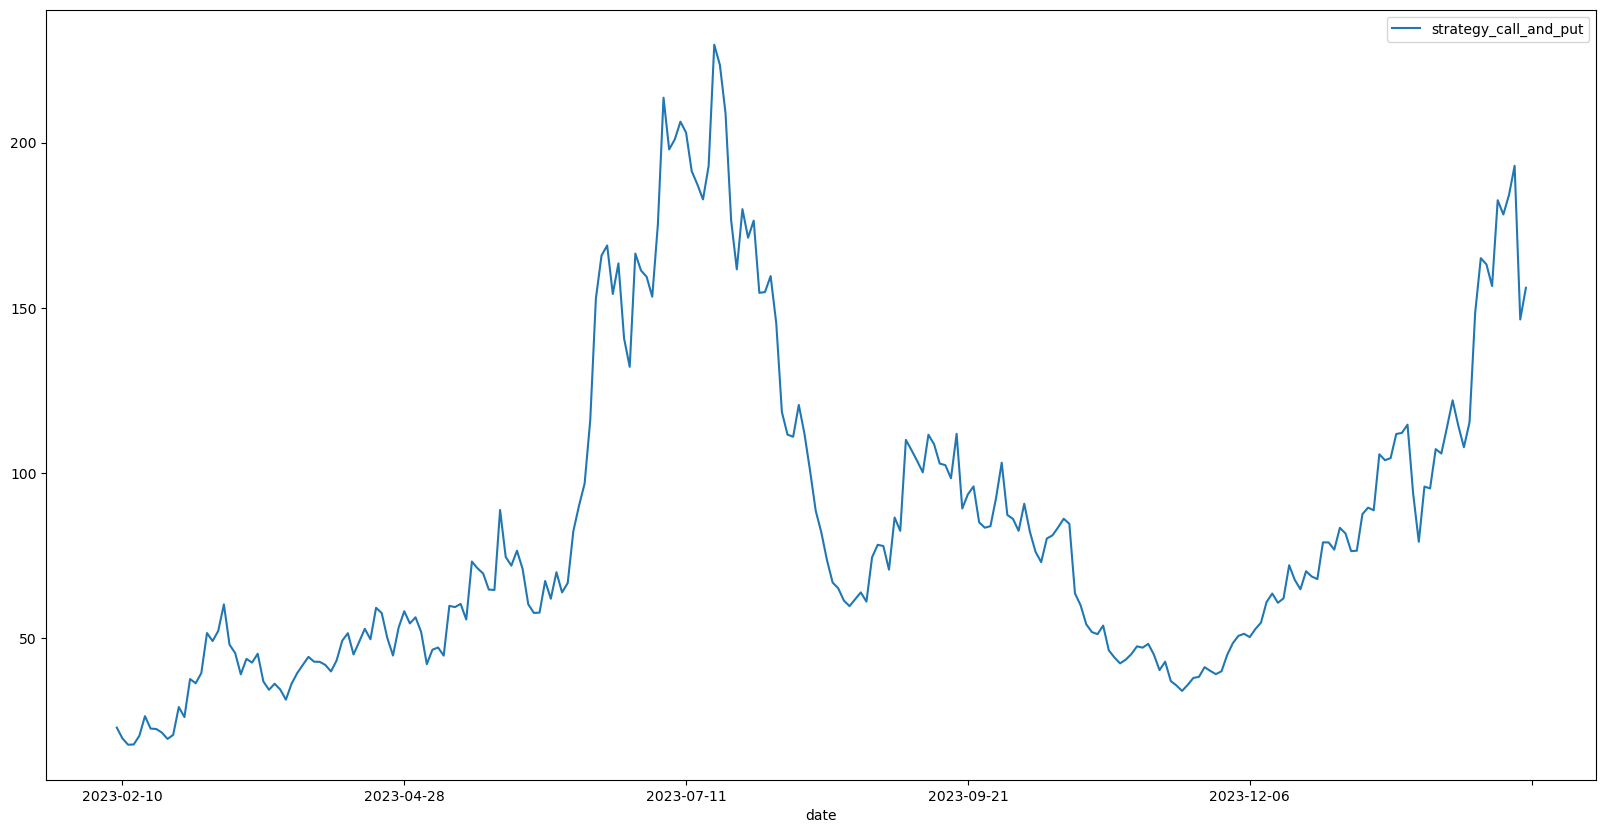

In [6]:
(1+selected_return_matrix).rolling(250).apply(lambda x: x.prod()).tail(400).plot(figsize=(20,10))

<Axes: xlabel='date'>

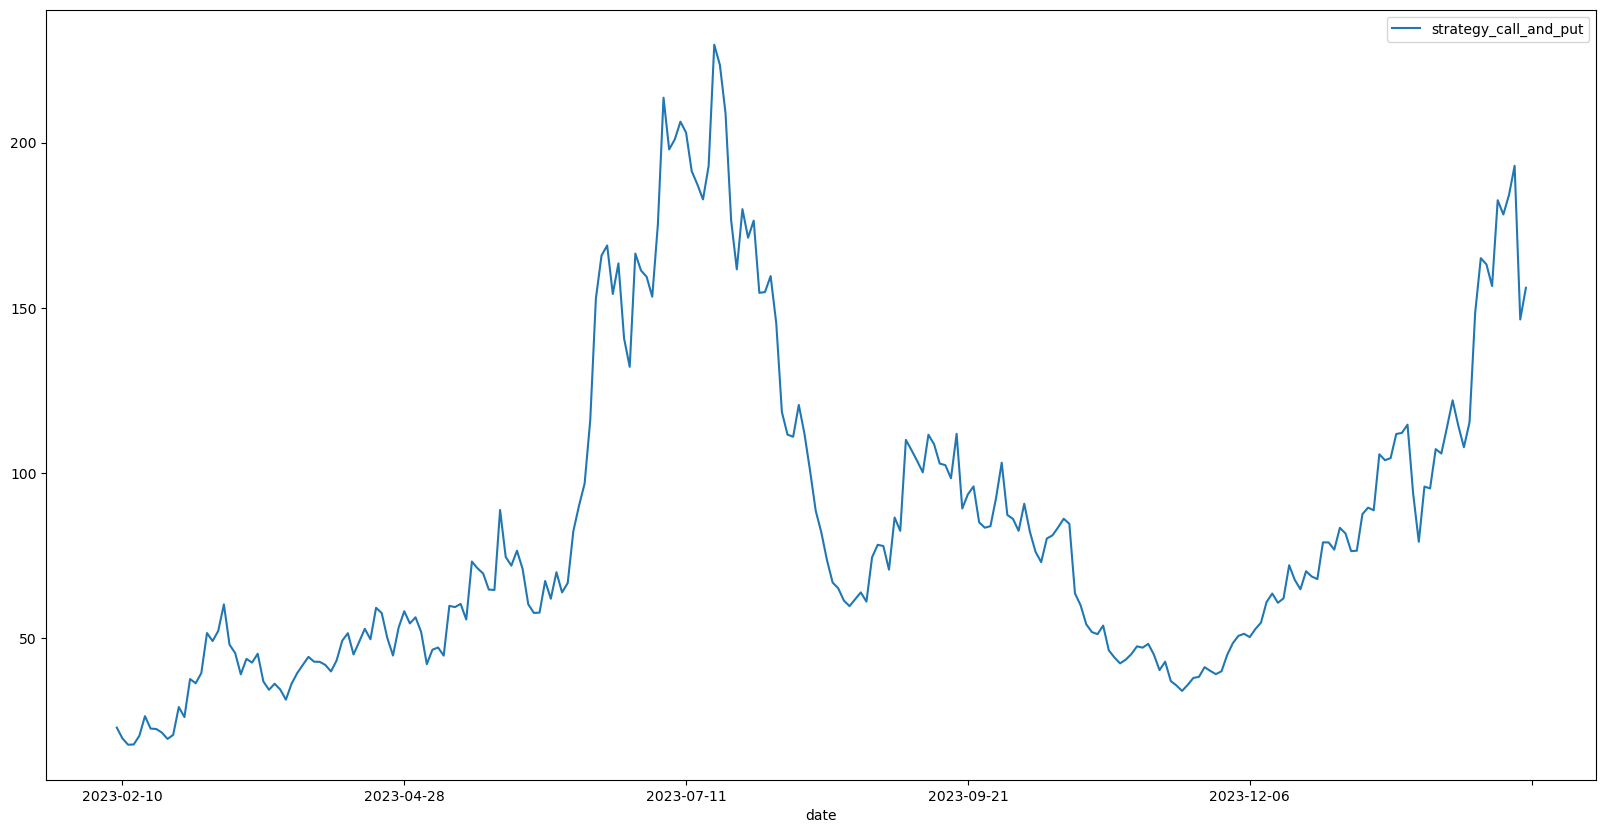

In [7]:
(1+selected_return_matrix).rolling(250).apply(lambda x: x.prod()).tail(800).plot(figsize=(20,10))

In [8]:
selected_return_matrix = []
for strategy, start, end, current_week in zip(['call_-1_0.25', 'call_-1_0.75', 'put_-0.75_1', 'call_-1_0',
       'call_-1_0.5'], [1, 8, 1, 9, 13], [9, 14, 14, 1, 13], [1, 2, 3, 4, 7]):
    selected_return_matrix.append(return_summary[(return_summary.start_holding_period == start) & 
                   (return_summary.end_holding_period == end) & 
                   (return_summary.current_week == current_week)][[strategy]].rename(columns = {strategy : "strategy_call_and_put"}))

selected_return_matrix = pd.concat(selected_return_matrix).sort_index()
self._generate_performance_stats(return_matrix_user=selected_return_matrix)
self.performance_stats

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
strategy_call_and_put,2.82342,2.14993,2.48896,6.70429,0.39830,15.68616,20.41021,65.69033,5.67194,0.01128,4.46026,35.35904,-0.62849,15,15


In [9]:
for lag in [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2228]:
    print(((1+selected_return_matrix.head(lag).tail(250)).cumprod()**(1/250)).tail(1))

            strategy_call_and_put
date                             
2023-02-09                1.00820
            strategy_call_and_put
date                             
2024-02-15                1.01436
            strategy_call_and_put
date                             
2024-02-15                1.01436
            strategy_call_and_put
date                             
2024-02-15                1.01436
            strategy_call_and_put
date                             
2024-02-15                1.01436
            strategy_call_and_put
date                             
2024-02-15                1.01436
            strategy_call_and_put
date                             
2024-02-15                1.01436
            strategy_call_and_put
date                             
2024-02-15                1.01436
            strategy_call_and_put
date                             
2024-02-15                1.01436


In [10]:
temp = summary.copy()
for metric in ['Sharpe', 'MDD', '250_Day_Median_Cumulative_Return', '60_Day_Median_Cumulative_Return',
               'Return', 'Last_250_Day_Cumulative_Return', 'Last_60_Day_Cumulative_Return']:
    temp = temp[temp[metric]>=temp[metric].quantile(0.7)]
    
temp

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
put_-0.75_0,2.87838,1.73573,1.78095,3.45279,0.70903,7.56331,8.16092,16.82044,3.40969,0.00825,2.97749,14.69650,-0.39897,1,8
call_-0.75_0,2.91979,1.73217,1.79728,3.36995,0.72268,7.79974,8.30435,16.00934,3.60566,0.00831,2.94501,14.00893,-0.39737,1,9
put_-0.75_0,3.06625,1.79193,1.85891,3.49074,0.74261,8.92974,9.52485,18.42640,4.12219,0.00886,3.05695,16.10901,-0.39706,1,9
call_-0.75_0,3.21785,1.84002,1.85396,3.64611,0.72984,11.56522,12.30950,26.36426,4.47637,0.00916,2.90844,18.26011,-0.38659,9,1
put_-0.75_0,3.36797,1.90073,1.91812,3.77765,0.75033,13.26650,14.15745,30.47560,5.11587,0.00971,3.01826,21.01277,-0.38618,9,1
put_-0.75_0,2.90396,1.71542,1.75336,3.61790,0.68727,9.23498,9.72181,20.60883,3.41325,0.00828,2.83096,15.51973,-0.38803,11,1


In [11]:
summary.sort_values("Sharpe", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-0.25,4.03762,2.36355,2.32181,4.05075,0.63164,33.17124,36.81566,84.16651,9.96260,0.01236,3.51231,41.13209,-0.56335,9,1
call_-1.5_-0.5,4.00653,2.01083,1.95904,3.17727,0.67325,17.17531,18.63888,35.88324,6.91172,0.00996,2.68068,18.70095,-0.50739,9,1
call_-1.25_-0.25,3.95141,2.21107,2.14318,3.50286,0.68396,24.33505,26.24819,56.90122,7.84080,0.01130,3.15830,30.98355,-0.49531,9,1
put_-0.75_-0.5,3.92491,1.33607,1.30650,1.59052,0.90696,3.27391,3.24991,4.30065,2.12609,0.00418,1.50633,3.61512,-0.18210,9,1
call_-1.5_-0.25,3.91732,2.29724,2.23817,3.70790,0.65254,28.61032,31.59694,70.22949,10.16345,0.01192,3.26689,32.51002,-0.53645,1,1


In [12]:
summary.sort_values("MDD", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
put_-0.75_-0.5,3.82399,1.31207,1.29377,1.55558,0.91566,3.12633,3.10137,4.04025,2.15289,0.00406,1.47684,3.34227,-0.16802,1,1
put_-0.75_-0.5,3.37614,1.27845,1.26518,1.58827,0.88019,2.91350,2.83768,3.70180,1.82915,0.00368,1.47907,3.27082,-0.16832,1,2
put_-0.5_-0.25,3.10317,1.27577,1.27384,1.68797,0.89090,2.79568,2.78166,3.72383,1.88434,0.00380,1.49446,3.27841,-0.16909,1,1
put_-0.5_-0.25,2.57705,1.23263,1.22567,1.64232,0.87963,2.37018,2.39146,3.30067,1.70048,0.00316,1.39800,2.62228,-0.17105,3,1
put_-0.5_-0.25,2.57723,1.23679,1.22791,1.65591,0.87131,2.38746,2.40294,3.30849,1.67550,0.00317,1.41230,2.68221,-0.17163,4,1


In [13]:
summary.sort_values("60_Day_Median_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0.25,3.28476,2.63258,2.76445,7.15564,0.35266,41.37017,47.99080,135.37795,6.37585,0.01330,6.34542,95.72535,-0.72676,9,10
call_-1.5_0,3.82395,2.61566,2.58898,4.94781,0.59210,46.51888,52.71958,141.35391,11.43283,0.01372,4.43553,67.30231,-0.60827,9,1
call_-1.5_0,3.56964,2.59225,2.59556,5.66685,0.40262,42.87153,45.96903,116.30890,7.13671,0.01303,5.12675,77.37086,-0.66459,9,10
call_-1.5_0.25,3.45494,2.58911,2.67049,5.95605,0.55064,42.89593,50.79919,155.29092,10.68012,0.01380,5.23159,72.30199,-0.64594,9,1
call_-1.5_0.25,3.22504,2.57501,2.65268,7.19823,0.41547,30.77815,35.67027,96.51420,6.55805,0.01292,6.23504,75.93074,-0.68312,9,9


In [14]:
summary.sort_values("60_Day_Mean_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0.5,2.96634,2.52620,2.78951,8.53057,0.30220,31.55487,39.65307,119.02064,4.79181,0.01267,7.20007,91.11355,-0.78299,9,10
call_-1.5_0.25,3.28476,2.63258,2.76445,7.15564,0.35266,41.37017,47.99080,135.37795,6.37585,0.01330,6.34542,95.72535,-0.72676,9,10
call_-1.5_0.5,2.85381,2.36419,2.71475,8.70913,0.36572,25.54723,33.25380,111.78824,4.70805,0.01209,6.64654,70.59071,-0.74138,9,13
call_-1.5_0.75,2.64682,2.38474,2.70334,9.72724,0.25205,20.92216,28.46527,88.59777,3.08236,0.01138,7.50991,73.22372,-0.83183,9,10
call_-1.5_0.25,3.15837,2.51481,2.68557,7.33880,0.41846,33.60278,40.09809,124.67712,6.24269,0.01274,5.91593,75.25347,-0.69476,9,13


In [15]:
summary.sort_values("60_Day_Max_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_1.25,1.91928,1.82848,2.29395,10.74836,0.20289,5.12056,8.65332,39.76311,0.77156,0.00692,6.93829,30.28284,-0.88840,9,14
call_-1.5_1.5,1.69403,1.63904,2.13746,10.65542,0.16647,3.60734,6.14227,30.58366,0.43989,0.00527,6.60712,23.05205,-0.91468,9,14
call_-1.5_1.25,2.01029,1.89368,2.34752,10.59929,0.21393,7.15566,11.57514,43.77334,1.01375,0.00755,6.62335,32.06519,-0.88196,9,13
call_-1.25_1.25,1.77374,1.70293,2.16460,10.57417,0.21096,3.45242,6.09646,29.04728,0.64445,0.00595,6.51413,22.19785,-0.87581,9,14
call_-1.5_1,2.18030,2.00346,2.45744,10.52329,0.25024,8.02047,12.67907,52.81879,1.38607,0.00865,7.23046,40.86577,-0.85277,9,14


In [16]:
summary.sort_values("60_Day_Min_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
put_-0.75_-0.5,3.82399,1.31207,1.29377,1.55558,0.91566,3.12633,3.10137,4.04025,2.15289,0.00406,1.47684,3.34227,-0.16802,1,1
put_-0.75_-0.5,3.92491,1.33607,1.30650,1.59052,0.90696,3.27391,3.24991,4.30065,2.12609,0.00418,1.50633,3.61512,-0.18210,9,1
put_-0.75_-0.5,3.38633,1.28547,1.26034,1.52387,0.90556,2.77964,2.79619,3.70282,1.96624,0.00360,1.40642,2.90486,-0.17213,3,1
put_-0.75_-0.5,3.35410,1.28485,1.26436,1.56784,0.89909,2.83117,2.79744,3.64867,1.87919,0.00364,1.46092,3.13953,-0.18365,15,1
put_-0.75_-0.5,3.40248,1.28725,1.26064,1.52374,0.89658,2.79733,2.79478,3.68205,1.95583,0.00361,1.41891,2.94788,-0.17302,2,1


In [17]:
summary.sort_values("250_Day_Median_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0,3.82395,2.61566,2.58898,4.94781,0.59210,46.51888,52.71958,141.35391,11.43283,0.01372,4.43553,67.30231,-0.60827,9,1
call_-1.5_0.25,3.45494,2.58911,2.67049,5.95605,0.55064,42.89593,50.79919,155.29092,10.68012,0.01380,5.23159,72.30199,-0.64594,9,1
call_-1.5_0,3.56964,2.59225,2.59556,5.66685,0.40262,42.87153,45.96903,116.30890,7.13671,0.01303,5.12675,77.37086,-0.66459,9,10
call_-1.5_0.25,3.28476,2.63258,2.76445,7.15564,0.35266,41.37017,47.99080,135.37795,6.37585,0.01330,6.34542,95.72535,-0.72676,9,10
call_-1.5_0,3.72064,2.51095,2.48407,4.45438,0.62487,39.08261,44.31968,114.03339,11.91834,0.01324,4.00301,51.00248,-0.57894,1,1


In [18]:
summary.sort_values("250_Day_Mean_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0,3.82395,2.61566,2.58898,4.94781,0.59210,46.51888,52.71958,141.35391,11.43283,0.01372,4.43553,67.30231,-0.60827,9,1
call_-1.5_0.25,3.45494,2.58911,2.67049,5.95605,0.55064,42.89593,50.79919,155.29092,10.68012,0.01380,5.23159,72.30199,-0.64594,9,1
call_-1.5_0.25,3.28476,2.63258,2.76445,7.15564,0.35266,41.37017,47.99080,135.37795,6.37585,0.01330,6.34542,95.72535,-0.72676,9,10
call_-1.5_0,3.56964,2.59225,2.59556,5.66685,0.40262,42.87153,45.96903,116.30890,7.13671,0.01303,5.12675,77.37086,-0.66459,9,10
call_-1.5_0,3.72064,2.51095,2.48407,4.45438,0.62487,39.08261,44.31968,114.03339,11.91834,0.01324,4.00301,51.00248,-0.57894,1,1


In [19]:
summary.sort_values("250_Day_Max_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0.25,3.45494,2.58911,2.67049,5.95605,0.55064,42.89593,50.79919,155.29092,10.68012,0.01380,5.23159,72.30199,-0.64594,9,1
call_-1.5_0,3.82395,2.61566,2.58898,4.94781,0.59210,46.51888,52.71958,141.35391,11.43283,0.01372,4.43553,67.30231,-0.60827,9,1
call_-1.5_0.25,3.28476,2.63258,2.76445,7.15564,0.35266,41.37017,47.99080,135.37795,6.37585,0.01330,6.34542,95.72535,-0.72676,9,10
call_-1.5_0.5,3.07009,2.42622,2.61334,6.60564,0.50228,31.28480,38.80949,131.39377,8.46186,0.01297,5.61499,58.79845,-0.67914,9,1
call_-1.5_0.25,3.15837,2.51481,2.68557,7.33880,0.41846,33.60278,40.09809,124.67712,6.24269,0.01274,5.91593,75.25347,-0.69476,9,13


In [20]:
summary.sort_values("250_Day_Min_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0,3.72064,2.51095,2.48407,4.45438,0.62487,39.08261,44.31968,114.03339,11.91834,0.01324,4.00301,51.00248,-0.57894,1,1
call_-1.5_0,3.82395,2.61566,2.58898,4.94781,0.59210,46.51888,52.71958,141.35391,11.43283,0.01372,4.43553,67.30231,-0.60827,9,1
call_-1.5_0.25,3.35138,2.55246,2.54119,5.18464,0.56042,35.36060,41.38832,120.34894,11.38176,0.01323,4.54178,51.15739,-0.61436,1,1
call_-1.5_0.25,3.45494,2.58911,2.67049,5.95605,0.55064,42.89593,50.79919,155.29092,10.68012,0.01380,5.23159,72.30199,-0.64594,9,1
call_-1.5_-0.25,3.91732,2.29724,2.23817,3.70790,0.65254,28.61032,31.59694,70.22949,10.16345,0.01192,3.26689,32.51002,-0.53645,1,1


In [21]:
summary.sort_values("Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0.25,3.45494,2.58911,2.67049,5.95605,0.55064,42.89593,50.79919,155.29092,10.68012,0.01380,5.23159,72.30199,-0.64594,9,1
call_-1.5_0,3.82395,2.61566,2.58898,4.94781,0.59210,46.51888,52.71958,141.35391,11.43283,0.01372,4.43553,67.30231,-0.60827,9,1
call_-1.5_0.25,3.28476,2.63258,2.76445,7.15564,0.35266,41.37017,47.99080,135.37795,6.37585,0.01330,6.34542,95.72535,-0.72676,9,10
call_-1.5_0,3.72064,2.51095,2.48407,4.45438,0.62487,39.08261,44.31968,114.03339,11.91834,0.01324,4.00301,51.00248,-0.57894,1,1
call_-1.5_0.25,3.35138,2.55246,2.54119,5.18464,0.56042,35.36060,41.38832,120.34894,11.38176,0.01323,4.54178,51.15739,-0.61436,1,1


In [22]:
summary.sort_values("Last_60_Day_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0.75,2.64682,2.38474,2.70334,9.72724,0.25205,20.92216,28.46527,88.59777,3.08236,0.01138,7.50991,73.22372,-0.83183,9,10
call_-1.5_1,2.34378,2.14982,2.54713,10.32047,0.20573,13.53545,19.28706,66.25621,1.78824,0.00972,7.37271,54.10848,-0.87171,9,10
call_-1.5_0.75,2.46780,2.18259,2.59053,9.84804,0.30715,12.49231,18.66659,68.58157,2.42543,0.01030,7.27962,54.20613,-0.80695,9,14
call_-1.5_0.75,2.56555,2.29870,2.56310,9.59344,0.30758,14.50237,19.56018,68.71677,3.04282,0.01082,7.26121,54.32311,-0.79172,9,9
call_-1.5_1,2.18030,2.00346,2.45744,10.52329,0.25024,8.02047,12.67907,52.81879,1.38607,0.00865,7.23046,40.86577,-0.85277,9,14


In [23]:
summary.sort_values("Last_250_Day_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0.25,3.14923,2.45181,2.54854,6.61333,0.38363,33.42851,38.07265,111.07099,4.17211,0.01250,6.02688,96.87591,-0.71011,9,5
call_-1.5_0.25,3.28476,2.63258,2.76445,7.15564,0.35266,41.37017,47.99080,135.37795,6.37585,0.01330,6.34542,95.72535,-0.72676,9,10
call_-1.5_0.25,3.09754,2.33690,2.52748,6.68562,0.38357,31.53232,37.20450,107.92142,3.70197,0.01226,5.89711,94.69769,-0.71750,9,4
call_-1.5_0.5,2.96634,2.52620,2.78951,8.53057,0.30220,31.55487,39.65307,119.02064,4.79181,0.01267,7.20007,91.11355,-0.78299,9,10
call_-1.5_0.5,2.80369,2.32549,2.50070,7.82080,0.33878,23.77711,29.00114,98.82555,3.00288,0.01163,6.59185,85.26580,-0.76543,9,5


In [ ]:
# summary.to_csv('Nifty_Full.csv')

In [ ]:
return_summary.to_csv('Nifty_Full_Sim.csv')

In [ ]:
(1 + self.return_matrix["call_-1_0.75"]).rolling(250).apply(lambda x: x.prod()).dropna().quantile(0.0025)

In [ ]:
27357.49229**(1/1000)

In [ ]:
import numpy as np
future = 21393
future*=np.exp(0.07*14/248)

In [ ]:
future*0.99

In [ ]:
future*1.005